In [1]:
import json
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

/Users/ashwin/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def get_data_and_do_everything(hashtag):
    dictionary = {'#GoHawks' : ['tweets_#gohawks.txt', 188136],
                    '#GoPatriots' : ['tweets_#gopatriots.txt', 26232],
                    '#NFL' : ['tweets_#nfl.txt', 259024],
                    '#Patriots' : ['tweets_#patriots.txt', 489713],
                    '#SB49' : ['tweets_#sb49.txt', 826951],
                    '#SuperBowl' : ['tweets_#superbowl.txt', 1348767]}
    
    time_stamp = np.zeros(dictionary[hashtag][1])
    tweets = [0]*dictionary[hashtag][1]
    followers_by_user = np.zeros(dictionary[hashtag][1])
    retweeted = [False] * dictionary[hashtag][1]
    user_mentions = np.zeros(dictionary[hashtag][1])
    hashtags_in_tweet = np.zeros(dictionary[hashtag][1])
    reply = [False] * dictionary[hashtag][1]
    favorite_count = np.zeros(dictionary[hashtag][1])
    verified = [False] * dictionary[hashtag][1]
    number_of_citations = np.zeros(dictionary[hashtag][1])
    ranking_scores = np.zeros(dictionary[hashtag][1])
    
    file = open('./tweet_data/'+dictionary[hashtag][0])
    for (line, index) in zip(file, range(0, dictionary[hashtag][1])):
        data = json.loads(line)
        time_stamp[index] = data['citation_date']
        tweets[index] = data['tweet']['text']
        followers_by_user[index] = data['author']['followers']
        author_name = data['author']['nick']
        original_author_name = data['original_author']['nick']
        if original_author_name != author_name:
            retweeted[index] = True
        user_mentions[index] = len(data['tweet']['entities']['user_mentions'])
        hashtags_in_tweet[index] = data['title'].count('#')
        if data['tweet']['in_reply_to_status_id'] != 'null':
            reply[index] = True
        favorite_count[index] = data['tweet']['favorite_count']
        if data['tweet']['user']['verified'] != 'False':
            reply[index] = True
        number_of_citations[index] = len(data['tweet']['entities']['urls'])
        ranking_scores[index] = data['metrics']['ranking_score']
    file.close()
    calculations(dictionary, hashtag, time_stamp, tweets, followers_by_user, retweeted, user_mentions, hashtags_in_tweet, reply, favorite_count, verified, number_of_citations, ranking_scores)

In [3]:
from string import punctuation
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

In [21]:
def calculations(dictionary, hashtag, time_stamp, tweets, followers_by_user, retweeted, user_mentions, hashtags_in_tweet, reply, favorite_count, verified, number_of_citations, ranking_scores):
    hour = int((max(time_stamp)-min(time_stamp))/3600)+1
    hourly_positive_tweets = [0]*(hour)
    hourly_negative_tweets = [0]*(hour)
    hourly_sentiment = [0]*(hour)
    hourly_number_of_tweets = [0]*(hour)
    time_of_day = [0]*(hour)
    hourly_retweet_number = [0]*(hour)
    hourly_sum_of_followers = [0]*(hour)
    hourly_max_follower = [0]*(hour)
    hourly_user_mentions = [0]*(hour)
    hourly_hashtags_in_tweet = [0]*(hour)
    hourly_reply = [0]*(hour)
    hourly_favorite_count = [0]*(hour)
    hourly_verified = [0]*(hour)
    hourly_number_of_citations = [0]*(hour)
    hourly_ranking_scores = [0]*(hour)
    hourly_mildly_positive = [0]*(hour)
    hourly_extremely_positive = [0]*(hour)
    hourly_mildly_negative = [0]*(hour)
    hourly_extremely_negative = [0]*(hour)
    
    start = min(time_stamp)
    for i in range(0, dictionary[hashtag][1]):
        current_hour = int((time_stamp[i] - start)/3600)
        if retweeted[i] == True:
            hourly_retweet_number[current_hour] += 1
        hourly_sum_of_followers[current_hour] += followers_by_user[i]
        if followers_by_user[i] > hourly_max_follower[current_hour]:
            hourly_max_follower[current_hour] = followers_by_user[i]
        hourly_user_mentions[current_hour] += user_mentions[i]
        hourly_hashtags_in_tweet[current_hour] += hashtags_in_tweet[i]
        if reply[i] == True:
            hourly_reply[current_hour] += 1
        hourly_favorite_count[current_hour] += favorite_count[i]
        if verified[i] == True:
            hourly_verified[current_hour] += 1
        hourly_number_of_citations[current_hour] += number_of_citations[i]
        hourly_ranking_scores[current_hour] += ranking_scores[i]
        #print(current_hour)
        #get sentiment
        tweet = strip_punctuation(tweets[i])
        blob = TextBlob(tweet)
        sentiment = blob.sentences[0].sentiment.polarity
        #add it to the hourly_sentiment
        hourly_sentiment[current_hour] += sentiment
        #add 1 to the hourly tweets such that we can get avg sentiment based on # of tweets
        hourly_number_of_tweets[current_hour] += 1
        #based on sentiment, add it to pos, neg
        if sentiment >= 0:
            hourly_positive_tweets[current_hour] += 1
            if sentiment < 0.3:
                hourly_mildly_positive[current_hour] += 1
            else:
                hourly_extremely_positive[current_hour] += 1
        else:
            hourly_negative_tweets[current_hour] += 1
            if sentiment > -0.3:
                hourly_mildly_negative[current_hour] += 1
            else:
                hourly_extremely_negative[current_hour] += 1
            
        for i in range(0, len(time_of_day)):
            time_of_day[i] = i%24

    length_of_hourly_tweets = list(range(len(hourly_positive_tweets)))
    average_hourly_sentiment = []
    for i in range(len(hourly_sentiment)):
        if hourly_number_of_tweets[i] != 0:
            avg_sentiment = hourly_sentiment[i]/hourly_number_of_tweets[i]
        else:
            avg_sentiment = 0
        average_hourly_sentiment.append(avg_sentiment)

        
        
    plot(hourly_positive_tweets, hourly_negative_tweets, average_hourly_sentiment, length_of_hourly_tweets, hourly_mildly_positive, hourly_extremely_positive, hourly_mildly_negative, hourly_extremely_negative)
    convert_to_df(hourly_number_of_tweets, hourly_retweet_number, hourly_sum_of_followers, hourly_max_follower, time_of_day, hourly_user_mentions, hourly_hashtags_in_tweet, hourly_reply, hourly_favorite_count, hourly_verified, hourly_number_of_citations, hourly_ranking_scores, hashtag, hourly_sentiment)

In [19]:
def plot(hourly_positive_tweets, hourly_negative_tweets, average_hourly_sentiment, length_of_hourly_tweets, hourly_mildly_positive, hourly_extremely_positive, hourly_mildly_negative, hourly_extremely_negative):
    
    #for i in range(len(length_of_hourly_tweets)):
    #    length_of_hourly_tweets[i] = length_of_hourly_tweets[i]/100
        
    plt.plot(length_of_hourly_tweets, hourly_positive_tweets)
    plt.xlabel('Hours')
    plt.ylabel('Number Of Positive Tweets')
    plt.title('Number Of Positive Tweets VS Hours')
    plt.show()
    
    plt.plot(length_of_hourly_tweets, hourly_mildly_positive)
    plt.xlabel('Hours')
    plt.ylabel('Number Of Mildly Positive Tweets')
    plt.title('Number Of Mildly Positive Tweets VS Hours')
    plt.show()
    
    plt.plot(length_of_hourly_tweets, hourly_extremely_positive)
    plt.xlabel('Hours')
    plt.ylabel('Number Of Extremely Positive Tweets')
    plt.title('Number Of Extremely Positive Tweets VS Hours')
    plt.show()
    
    plt.plot(length_of_hourly_tweets, hourly_negative_tweets)
    plt.xlabel('Hours')
    plt.ylabel('Number Of Negative Tweets')
    plt.title('Number Of Negative Tweets VS Hours')
    plt.show()
    
    plt.plot(length_of_hourly_tweets, hourly_mildly_negative)
    plt.xlabel('Hours')
    plt.ylabel('Number Of Mildly Negative Tweets')
    plt.title('Number Of Mildly Negative Tweets VS Hours')
    plt.show()
    
    plt.plot(length_of_hourly_tweets, hourly_extremely_negative)
    plt.xlabel('Hours')
    plt.ylabel('Number Of Extremely Negative Tweets')
    plt.title('Number Of Extremely Negative Tweets VS Hours')
    plt.show()
    
    plt.plot(length_of_hourly_tweets, average_hourly_sentiment)
    plt.xlabel('Hours')
    plt.ylabel('Average Hourly Sentiment')
    plt.title('Average Hourly Sentiment VS Hours')
    plt.show()

Do something similar to 1c where we predict the sentiment of the next hour's tweets based on the previous hour

In [6]:
def convert_to_df(hourly_number_of_tweets, hourly_retweet_number, hourly_sum_of_followers, hourly_max_follower, time_of_day, hourly_user_mentions, hourly_hashtags_in_tweet, hourly_reply, hourly_favorite_count, hourly_verified, hourly_number_of_citations, hourly_ranking_scores, hashtag, hourly_sentiment):
    target_value = hourly_sentiment[1:]
    target_value.append(0)
    full_data = np.array([hourly_number_of_tweets, hourly_retweet_number, hourly_sum_of_followers, hourly_max_follower, time_of_day, hourly_user_mentions, hourly_hashtags_in_tweet, hourly_reply, hourly_favorite_count, hourly_verified, hourly_number_of_citations, hourly_ranking_scores, hourly_sentiment, target_value])
    full_data = np.transpose(full_data)
    data_frame = DataFrame(full_data)
    data_frame.columns = ['hourly_tweet_number', 'hourly_retweet_number', 'hourly_sum_of_followers', 'hourly_max_follower', 'time_of_day', 'hourly_user_mentions', 'hourly_hashtags_in_tweet', 'hourly_reply', 'hourly_favorite_count', 'hourly_verified', 'hourly_number_of_citations', 'hourly_ranking_scores', 'hourly_sentiment','target_value']
    linear_regression(data_frame, hashtag)

In [7]:
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [8]:
def linear_regression(data_frame, hashtag):
    #need to one hot encode time of day
    training_data = one_hot(data_frame, ['time_of_day'])
    training_data.drop('time_of_day', 1, inplace=True)
    target_data = training_data.pop('target_value')
    linear_reg = LinearRegression(fit_intercept = False)
    linear_regression_fitted = linear_reg.fit(training_data, target_data)
    
    predicted = linear_regression_fitted.predict(training_data)
    RMSE = calculate_RMSE(predicted, target_data)
    print('RMSE is:', RMSE)
    perform_t_test(target_data, training_data)
    plot_final(target_data, predicted, hashtag)

In [9]:
def calculate_RMSE(predicted, actual):  
    return np.sqrt(np.mean((predicted - actual) ** 2))  

In [10]:
def perform_t_test(target_data, training_data):
    model = sm.OLS(target_data, training_data)
    results = model.fit()
    print(results.summary())

In [11]:
def plot_final(target_data, predicted, hashtag):
    plt.scatter(target_data, predicted)
    plt.plot([target_data.min(), target_data.max()], [target_data.min(), target_data.max()])
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    plt.title('Predicted Value VS Actual Value ' + str(hashtag))
    plt.show()

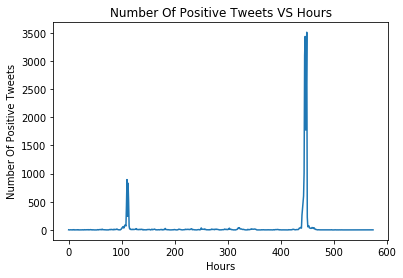

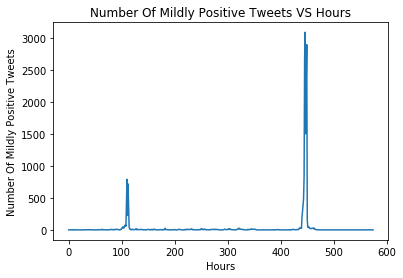

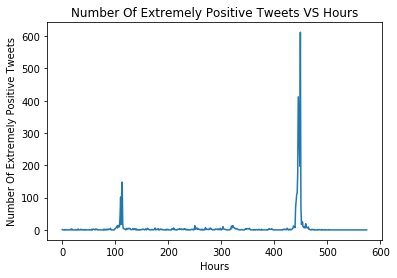

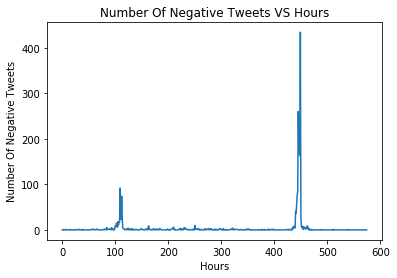

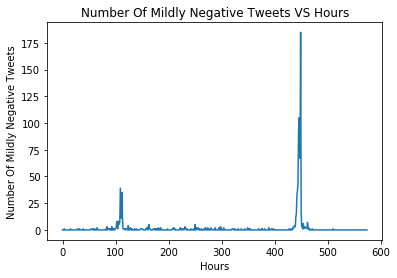

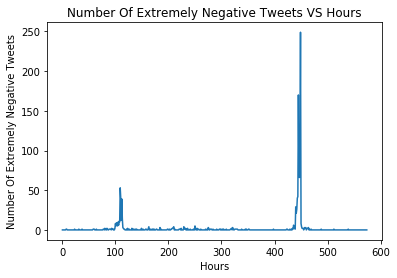

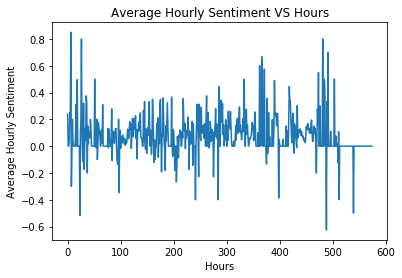

RMSE is: 6.25387564183
                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     99.87
Date:                Thu, 15 Mar 2018   Prob (F-statistic):          1.07e-206
Time:                        00:04:48   Log-Likelihood:                -1870.0
No. Observations:                 575   AIC:                             3808.
Df Residuals:                     541   BIC:                             3956.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

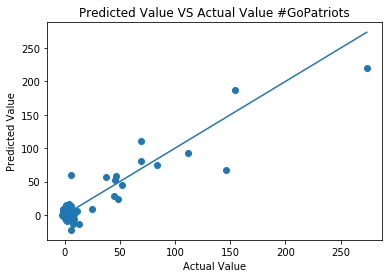

In [22]:
get_data_and_do_everything('#GoPatriots')

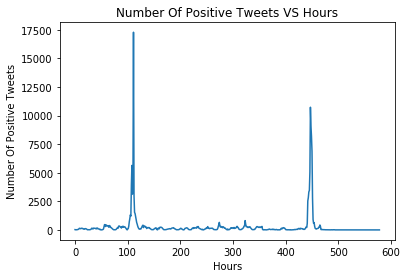

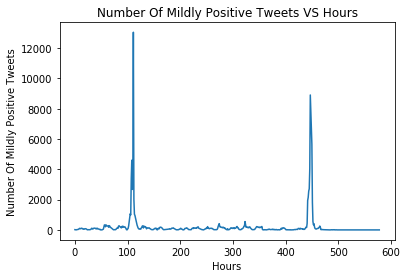

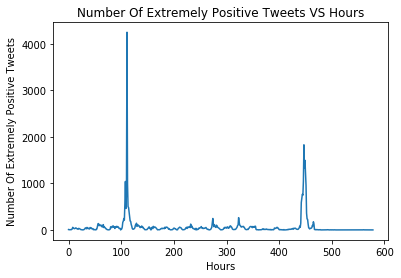

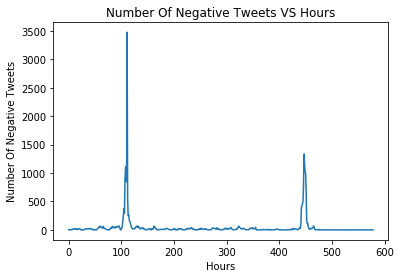

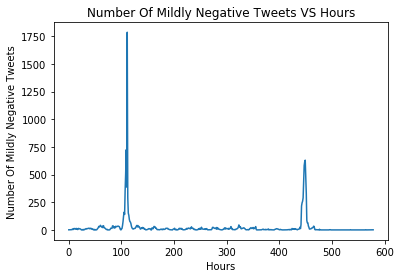

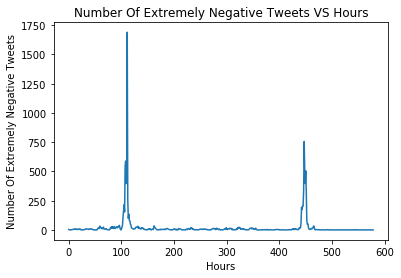

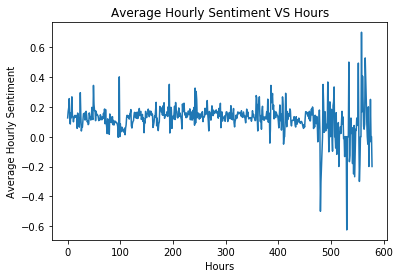

RMSE is: 57.9512553338
                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     32.88
Date:                Thu, 15 Mar 2018   Prob (F-statistic):          7.01e-108
Time:                        00:07:55   Log-Likelihood:                -3172.1
No. Observations:                 579   AIC:                             6412.
Df Residuals:                     545   BIC:                             6560.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

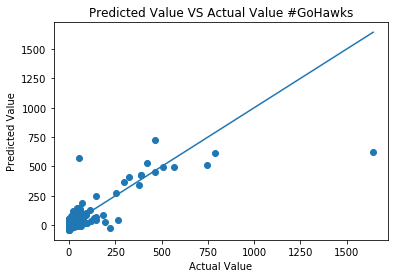

In [23]:
get_data_and_do_everything('#GoHawks')

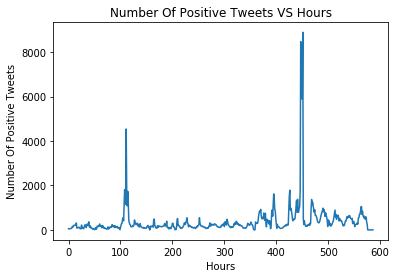

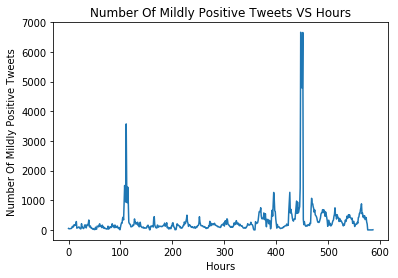

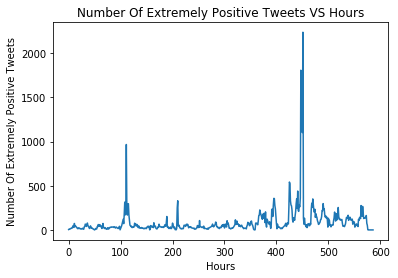

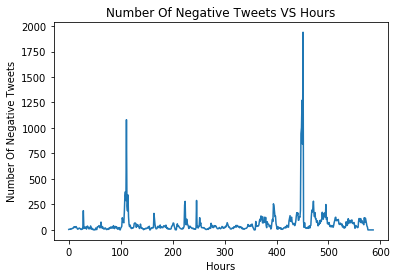

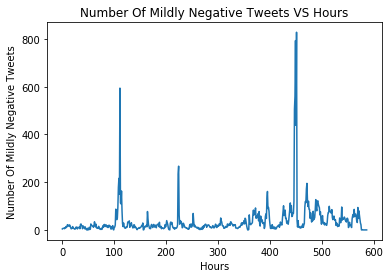

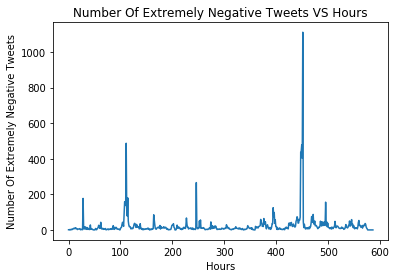

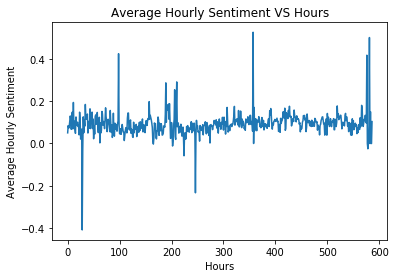

RMSE is: 41.6701001737
                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     34.22
Date:                Thu, 15 Mar 2018   Prob (F-statistic):          1.16e-111
Time:                        00:14:16   Log-Likelihood:                -3022.3
No. Observations:                 587   AIC:                             6113.
Df Residuals:                     553   BIC:                             6261.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

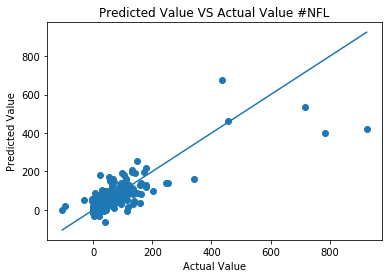

In [24]:
get_data_and_do_everything('#NFL')

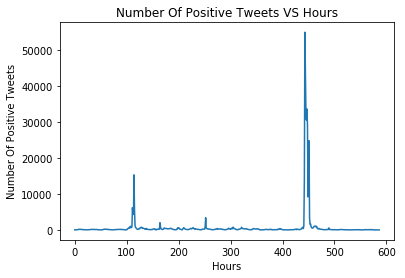

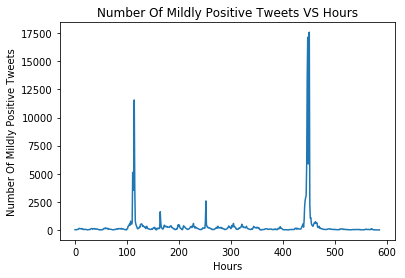

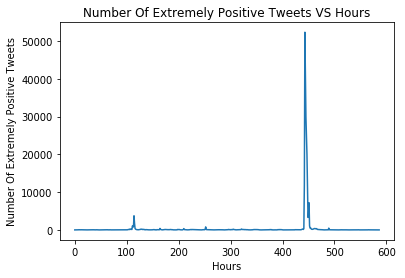

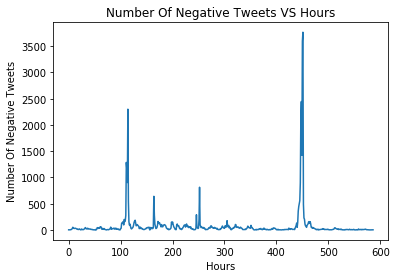

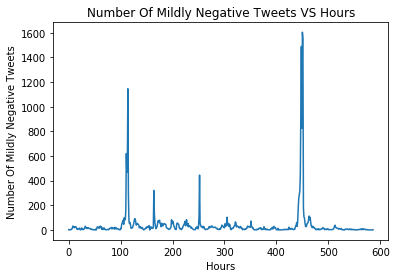

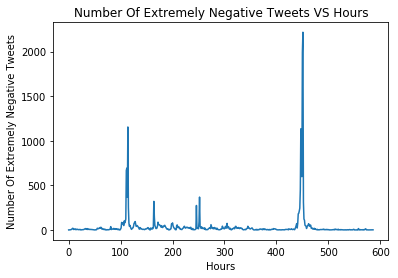

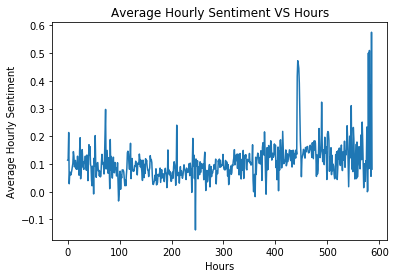

RMSE is: 874.940864691
                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     44.73
Date:                Thu, 15 Mar 2018   Prob (F-statistic):          1.24e-133
Time:                        00:23:56   Log-Likelihood:                -4804.1
No. Observations:                 587   AIC:                             9676.
Df Residuals:                     553   BIC:                             9825.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

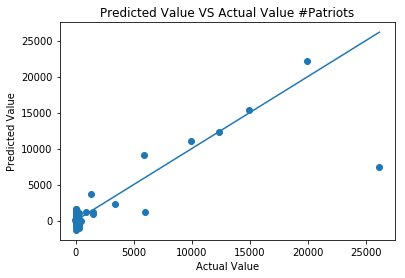

In [25]:
get_data_and_do_everything('#Patriots')

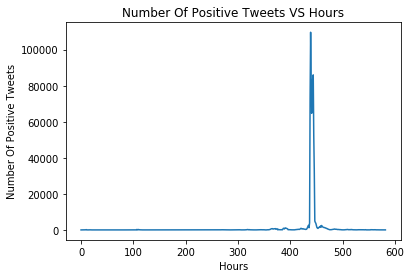

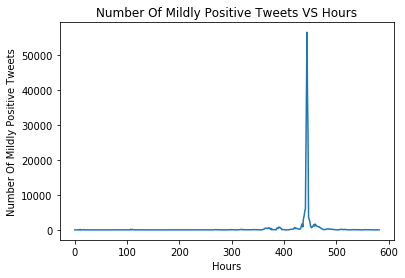

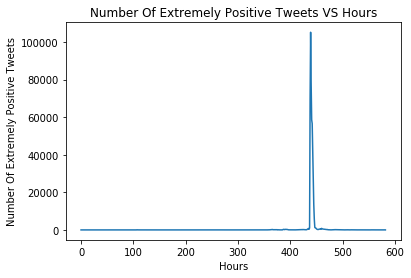

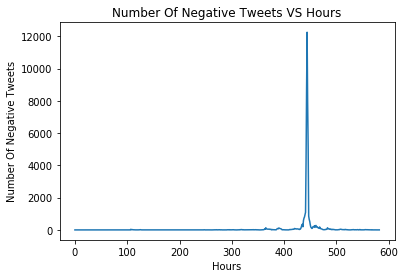

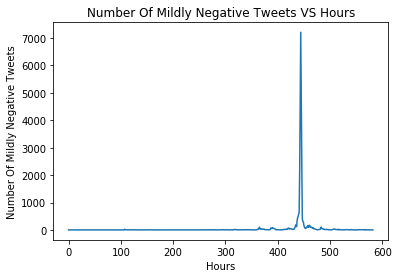

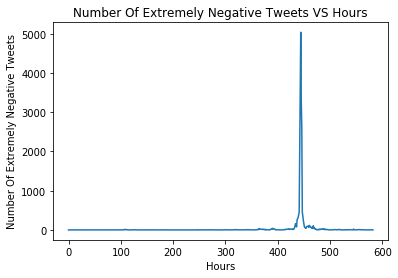

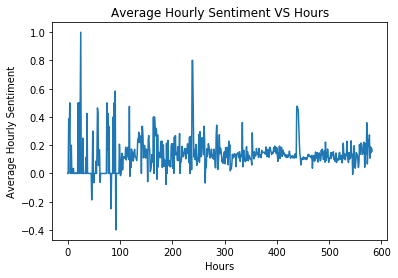

RMSE is: 1479.93566836
                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     84.11
Date:                Thu, 15 Mar 2018   Prob (F-statistic):          2.32e-191
Time:                        00:38:39   Log-Likelihood:                -5083.0
No. Observations:                 583   AIC:                         1.023e+04
Df Residuals:                     549   BIC:                         1.038e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

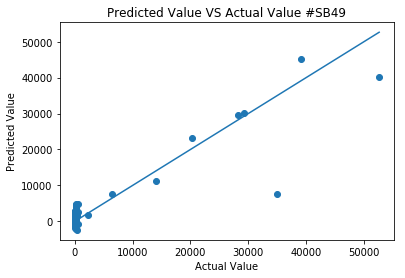

In [26]:
get_data_and_do_everything('#SB49')

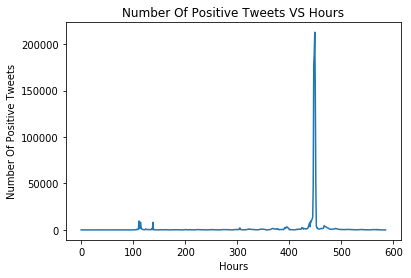

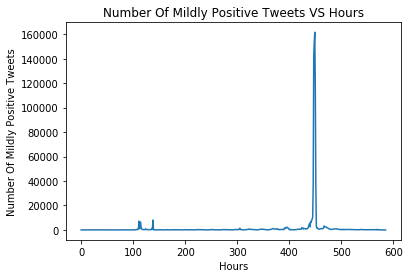

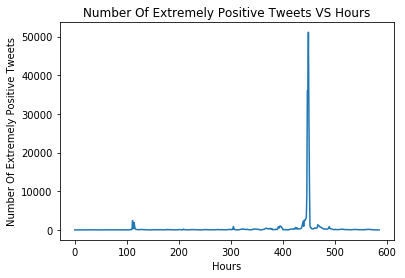

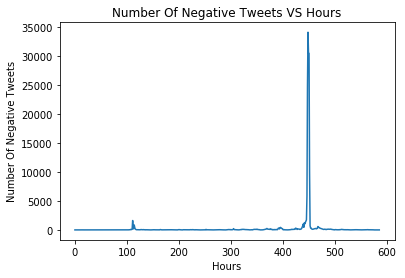

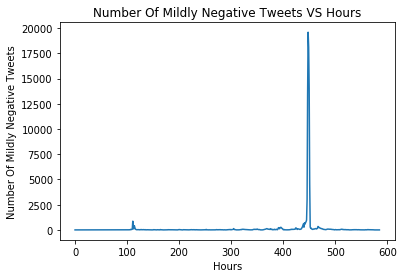

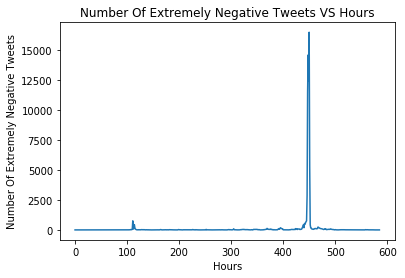

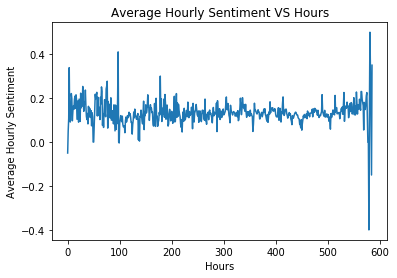

RMSE is: 435.352814129
                            OLS Regression Results                            
Dep. Variable:           target_value   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     169.5
Date:                Thu, 15 Mar 2018   Prob (F-statistic):          6.75e-265
Time:                        00:56:00   Log-Likelihood:                -4392.1
No. Observations:                 586   AIC:                             8852.
Df Residuals:                     552   BIC:                             9001.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

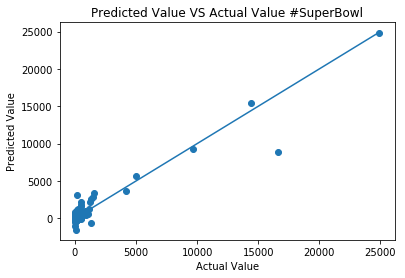

In [27]:
get_data_and_do_everything('#SuperBowl')